In [15]:
import gym
import numpy as np
import torch
from collections import deque
from collections import OrderedDict
import pylab as plt
np.random.seed(100)
torch.manual_seed(100)

In [16]:
# generate noise according to shape of parameters in network
def getNoise(policyBase, sigma):
    params = policyBase.state_dict()
    noise = OrderedDict()
    for p in params:
        n = torch.from_numpy(sigma * np.random.randn(*params[p].shape)).float()
        noise[p] = n
    return noise

# apply noise to a policy to get perturbed policy
def getPerturbedPolicy(baseParams, policyClass, policyBase, noise):
    newPolicy = policyClass(*baseParams)
    params = policyBase.state_dict()
    for p in params:
        params[p] += noise[p]
    newPolicy.load_state_dict(params)
    return newPolicy

# update params based on rewards of population in one generation
def updateParams(params, noises, rewards, population, sigma, lr):
    # print(rewards)
    rewards = (np.array(rewards) - np.mean(rewards)) / (np.std(rewards) + 1)
    # print(rewards)
    for i in range(len(rewards)):
        for p in params:
            params[p] += lr * noises[i][p] * rewards[i]/(population * sigma)
    return params

# run simulation to see behaviour of policy on env
def showPolicy(env, policy, max_steps):
    episode_reward = 0
    state = env.reset()
    for s in range(max_steps):
        env.render()
        action = torch.argmax(policy.forward(torch.FloatTensor(state)))
        state, reward, done, _ = env.step(int(action))
        episode_reward += reward
        if done:
            break
    env.close()
    return episode_reward

# run a episode and get full reward of it
def getReward(env, policy_network, max_steps):
    episode_reward = 0
    state = env.reset()
    for s in range(max_steps):
        action = torch.argmax(policy_network.forward(torch.FloatTensor(state)))
        state, reward, done, _ = env.step(int(action))
        episode_reward += reward
        if done:
            break
    return episode_reward

# test the policy for n episodes to see the average reward and whether the policy works
def getAvgPerformance(env, policy, episodes, max_steps):
    rewards = []
    
    for i in range(episodes):
        state = env.reset()
        episode_reward = 0
        for s in range(max_steps):
            action = torch.argmax(policy.forward(torch.FloatTensor(state)))
            state, reward, done, _ = env.step(int(action))
            episode_reward += reward
            if done:
                break
        rewards.append(episode_reward)
    return np.mean(episode_reward)
        

In [17]:
# Evolutionary stratefy
# env: gym environment
# policyClass: pass the class of torch network as new are generated in each generation with different parameters
# params: pass params (size of layers in torch network)
# sigma: multiplier for noise
# lr: learning rate
# population: number of policies to generate in each generation
# iterations: number of generations
# max_steps: number of max steps for env simulation
# threshold: if policy gives reward > threshold for 5 times then do early stopping
# sigma_decay: multiplier to sigma to decay so there is more pertubation in beginning and fewer later in thr progression
def es(env, policyClass, params, sigma, lr, population, iterations, max_steps, threshold, sigma_decay):
    currentPolicy = policyClass(*params)
    best_params = currentPolicy.state_dict()
    best_reward = -10000
    avgRewards = []
    shortAvgRewards = deque(maxlen=5)
    for _ in range(iterations):
        updatedParams = currentPolicy.state_dict()
        rewards = []
        noises = []
        for __ in range(population):
            noise = getNoise(currentPolicy, sigma)
            noises.append(noise)
            individual = getPerturbedPolicy(params, policyClass, currentPolicy, noise)
            reward = getReward(env, individual, max_steps)
            rewards.append(reward)
        updatedParams = updateParams(updatedParams, noises, rewards, population, sigma, lr)
        avgReward = np.mean(rewards)
        if(avgReward >= best_reward):
            print("iteration: ", _, "Reward: ", avgReward)
            best_reward = avgReward
            best_params = currentPolicy.state_dict()
        currentPolicy.load_state_dict(updatedParams)

        avgRewards.append(avgReward)
        shortAvgRewards.append(avgReward)
        if(np.mean(shortAvgRewards) > threshold):
            print(str(_) + " total iterations")
            break
        
        if (_ %100 == 0):
            print("iteration: ", _, "Reward: ", avgReward)
        sigma **= sigma_decay
        
        
    return best_params, avgRewards
        

# Inverted Pole
***

In [18]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self,x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        return x

In [19]:
policy_params = [4, 20, 2]
env = gym.make('CartPole-v0')
env.seed(100)
best_params, rewards = es(env, Net, policy_params, .01, .00001, 20, 4000, 200, 195, 1)

iteration:  0 Reward:  9.3
iteration:  0 Reward:  9.3
iteration:  1 Reward:  9.3
iteration:  3 Reward:  9.5
iteration:  9 Reward:  9.95
iteration:  10 Reward:  10.0
iteration:  11 Reward:  10.25
iteration:  100 Reward:  9.2
iteration:  200 Reward:  9.5
iteration:  295 Reward:  14.75
iteration:  296 Reward:  22.15
iteration:  297 Reward:  28.5
iteration:  300 Reward:  12.0
iteration:  400 Reward:  9.5
iteration:  500 Reward:  9.5
iteration:  600 Reward:  9.1
iteration:  640 Reward:  29.45
iteration:  642 Reward:  36.6
iteration:  645 Reward:  39.85
iteration:  660 Reward:  40.7
iteration:  679 Reward:  40.8
iteration:  680 Reward:  46.85
iteration:  681 Reward:  49.35
iteration:  682 Reward:  51.65
iteration:  683 Reward:  56.05
iteration:  684 Reward:  67.8
iteration:  689 Reward:  92.5
iteration:  700 Reward:  46.45
iteration:  705 Reward:  103.35
iteration:  706 Reward:  126.5
iteration:  800 Reward:  15.8
iteration:  900 Reward:  30.8
iteration:  1000 Reward:  17.65
iteration:  1100

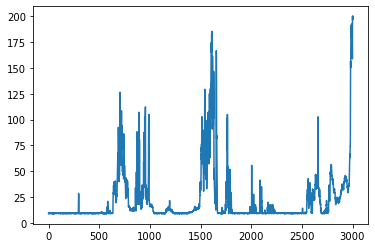

In [20]:
plt.plot(rewards)

In [21]:
bestPolicy = Net(*policy_params)
bestPolicy.load_state_dict(best_params)

In [22]:
showPolicy(env, bestPolicy, 200)

200.0

In [23]:
getAvgPerformance(env, bestPolicy, 200, 200)

200.0

# Lunar lander
*****

In [24]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(Net,self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.layer1 = torch.nn.Linear(input_size, hidden_size1)
        self.layer2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = torch.nn.Linear(hidden_size2, output_size)
    
    def forward(self,x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        # x = torch.nn.Softmax(dim=0)(x)
        # x = torch.sigmoid(x)
        return x

In [25]:
policy_params = [8, 256, 256, 4]
env = gym.make("LunarLander-v2")
env.seed(100)
best_params, rewards = es(env, Net, policy_params, 1, .00001, 10, 5000, 1000, 200, .999)

iteration:  0 Reward:  -247.70026560487463
iteration:  0 Reward:  -247.70026560487463
iteration:  4 Reward:  -208.03049071021843
iteration:  30 Reward:  -195.22568145079572
iteration:  31 Reward:  -145.77675100788503
iteration:  43 Reward:  -138.59011490898527
iteration:  44 Reward:  -137.26948623484213
iteration:  45 Reward:  -119.54647307855092
iteration:  53 Reward:  -114.07062121741194
iteration:  100 Reward:  -494.9621281370466
iteration:  200 Reward:  -538.8099852028099
iteration:  300 Reward:  -527.9760987873514
iteration:  400 Reward:  -560.7017513809461
iteration:  500 Reward:  -581.6740953266499
iteration:  600 Reward:  -625.2932248904378
iteration:  700 Reward:  -902.1405568155396
iteration:  800 Reward:  -1129.0915575670074
iteration:  900 Reward:  -912.1373868532928
iteration:  1000 Reward:  -773.3264304387712
iteration:  1100 Reward:  -694.8292837788213
iteration:  1200 Reward:  -752.8240471122024
iteration:  1300 Reward:  -713.031368451743
iteration:  1400 Reward:  -579.

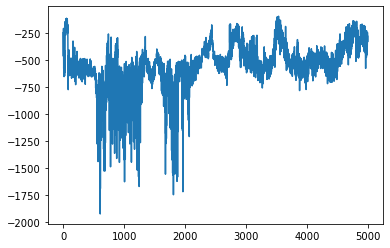

In [26]:
plt.plot(rewards)

In [37]:
bestPolicy = Net(*policy_params)
bestPolicy.load_state_dict(best_params)
showPolicy(env, bestPolicy, 1000)

-282.1525911524937